# Assignment 8 - Load Default RF and under&over sampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
import plotly.express as px
import scipy.stats as stats
import plotly.io as pio
pio.renderers.default = "notebook"

In [2]:
#read data
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df_dict = pd.read_excel('Variables_Dictionary_2019.xlsx')

# 1. Data Preparation

In [3]:
#Transform the values into numeric format before plotting and working analysis
#df = df.apply(pd.to_numeric, errors='coerce') 

#clean the variable dictionary data
df_dict = df_dict.drop(df_dict.columns[0], axis=1)
df_dict = df_dict.drop(df_dict.index[:3])
df_dict.columns = ['NO.', 'Var', 'dtypes', 'description', 'Var_Category']

#drop first 3 and empty columns
df1 = df.drop(df.columns[:3], axis=1)
columns_to_drop = ['TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062']
df1 = df1.drop(columns=columns_to_drop)

#Transform date format
df1['AP005'] = pd.to_datetime(df1['AP005'], format='%Y/%m/%d %H:%M').dt.strftime('%Y-%m-%d %H:%M:%S')
df1.head()

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,...,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,31,2,1,12,2017-07-06 10:21:00,ios,3,3,1,...,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,0,27,1,1,12,2017-04-06 12:51:00,h5,5,4,0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB
2,0,33,1,4,12,2017-07-01 14:11:00,h5,4,2,0,...,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB
3,0,34,2,4,12,2017-07-07 10:10:00,android,5,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO
4,0,47,2,1,12,2017-07-06 14:37:00,h5,4,4,1,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [4]:
#Encode categorical values
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ['AP006', 'MB007']:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le  # store the label encoder for potential inverse transformation later

#df1 column name references the variable dictionary by joining the content and if NaN keep the original column name
df1.columns = df1.columns.map(lambda col: df_dict.set_index('Var').loc[col, 'description'] if col in df_dict['Var'].values else col)
df1.columns.values[0] = 'Loan_Default'

#Change the last column name to tech_gadget
df1.columns = list(df1.columns[:-1]) + ['tech_gadget']
df1.head()

#change the target column to categorical column
df1['Loan_Default'] = df1['Loan_Default'].astype('category')


In [5]:
print(df1.columns)

Index(['Loan_Default', 'YR_AGE', 'CODE_GENDER', 'CODE_EDUCATION', 'LOAN_TERM',
       'DATE_APPLIED', 'OS_TYPE', 'LEVEL_APPL_CITY',
       'FLAG_IP_CITY_NOT_APPL_CITY', 'AP009', 'TD_CNT_QUERY_LAST_7Day_P2P',
       'TD_CNT_QUERY_LAST_7Day_SMALL_LOAN', 'TD_CNT_QUERY_LAST_1MON_P2P',
       'TD_CNT_QUERY_LAST_1MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_3MON_P2P',
       'TD_CNT_QUERY_LAST_3MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_P2P',
       'TD_CNT_QUERY_LAST_6MON_SMALL_LOAN', 'TD_CNT_QUERY_LAST_6MON_BANK',
       'TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'CNT_QUERY_TIME_LAST_1MON', 'CNT_QUERY_TIME_LAST_2MON',
       'AMT_LOAN_TOTAL', 'FLAG_CREDIT_CARD_ACCT_OVER_8',
       'MONTH_CREDIT_CARD_MOB_MAX', 'SCORE_DEBIT_CARD_TOTAL_AMT',
       'SCORE_DEBIT_CARD_UTILITY_AMT', 'SCORE_SINGLE_DEBIT_CARD_LIMIT',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL',
       'DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_CALL',
       'AVG_LEN_COLLECTION_OR_H

In [6]:
#drop the NaN values
df1 = df1.dropna()

In [7]:
#check if df1 has missing values
missing_values = df1.isnull().any().any()

missing_values

False

# 2. Modeling with Variables

In [10]:
#convert the date to non string format
df1['DATE_APPLIED'] = pd.to_datetime(df1['DATE_APPLIED']).astype(np.int64) // 10**9

#cross validation
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(df1[features],
                                                    df1['Loan_Default'], 
                                                    random_state=1234)
#drop na
combined = pd.concat([X_train, Y_train], axis=1)
combined.dropna(inplace=True)
X_train = combined.drop(Y_train.name, axis=1)
Y_train = combined[Y_train.name]

Before using sampling methods, I would run the RF model to drop potential redundant variables

In [23]:
#model the data first to drop redundant variables
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)

# Get feature importances
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

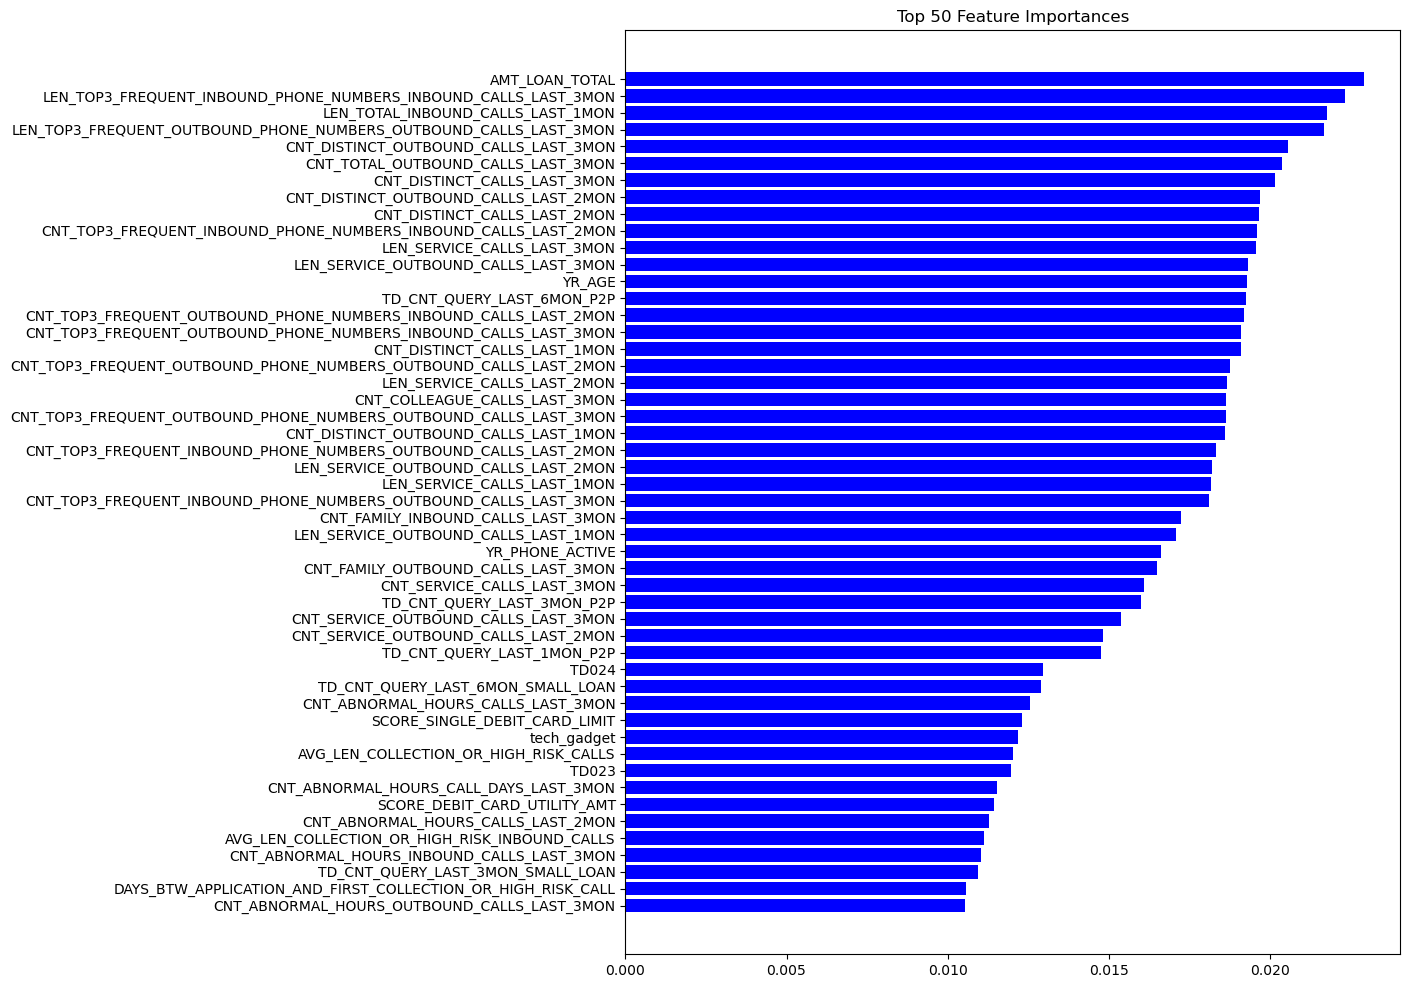

In [88]:
# Get the top 40 feature names and their importance values
top_indices = indices[:50]
top_features = [features[i] for i in top_indices] 
top_importance_values = importances[top_indices]

# Plot
plt.figure(figsize=(10,12))
plt.title("Top 50 Feature Importances")
plt.barh(top_features, top_importance_values, color="b", align="center")
plt.gca().invert_yaxis()
plt.show()

In [89]:
#drop the redundant variables in df1
X_train, X_test, Y_train, Y_test = train_test_split(df1[top_features],
                                                    df1['Loan_Default'], 
                                                    random_state=1234)

## 2.1 Under-sampling with Random Forest

### TomekLinks
1. An under-sampling method
2. Deal with imbalanced data
3. Identify and remove certain instances from the majority class to make the datasets more balanced
4. A pair of instances from two different classes such that they are nearest neighbors of each other
5. A conservative method while it doesn't remove a large number of instances, preserving most of the information from the majority class.

In [90]:
from sklearn.decomposition import PCA
import pylab as pl

def plot_this(X_rs,y_rs,method):
  # Use principal component to condense whole features to 2 features
  pca = PCA(n_components=2).fit(X_rs)
  pca_2d = pca.transform(X_rs)
  # Assign colors
  for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 0:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='o')
    elif y_rs[i] == 1:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='*')  
  pl.legend([c1, c2], ['Class 1', 'Class 2'])
  pl.title(method)
  pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
  pl.show()

In [91]:
from imblearn.under_sampling import TomekLinks
from collections import Counter

sampler = TomekLinks() 
X_rs, y_rs = sampler.fit_resample(X_train, Y_train)
print('TomekLinks undersampling {}'.format(Counter(y_rs)))
#plot_this(X_rs,y_rs,'TomekLinks')

TomekLinks undersampling Counter({0: 31042, 1: 9013})


## Random Forest with Tomek Links method

In [92]:
#import h2o
#h2o.init()
df = pd.concat([X_rs, y_rs], axis=1)
df

,AMT_LOAN_TOTAL,LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON,LEN_TOTAL_INBOUND_CALLS_LAST_1MON,LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON,CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON,CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON,CNT_DISTINCT_CALLS_LAST_3MON,CNT_DISTINCT_OUTBOUND_CALLS_LAST_2MON,CNT_DISTINCT_CALLS_LAST_2MON,CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON,...,TD023,CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON,SCORE_DEBIT_CARD_UTILITY_AMT,CNT_ABNORMAL_HOURS_CALLS_LAST_2MON,AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS,CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_3MON,TD_CNT_QUERY_LAST_3MON_SMALL_LOAN,DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL,CNT_ABNORMAL_HOURS_OUTBOUND_CALLS_LAST_3MON,Loan_Default
0,52000,21593.0,4268.0,37922.0,107.0,323.0,153.0,56.0,77.0,82.0,...,6.0,7.0,8,6.0,24.000000,7.0,1,72.0,5.0,0
1,2000,43833.0,32107.0,81342.0,138.0,1194.0,238.0,105.0,193.0,301.0,...,12.0,2.0,3,4.0,-98.000000,4.0,4,-1.0,1.0,0
2,2700,7913.0,11701.0,3265.0,27.0,129.0,44.0,27.0,44.0,42.0,...,6.0,0.0,4,0.0,27.000000,0.0,0,14.0,0.0,0
3,251000,8003.0,6257.0,11334.0,85.0,184.0,117.0,64.0,85.0,70.0,...,0.0,1.0,8,1.0,-98.000000,0.0,0,-1.0,1.0,0
4,6600,45260.0,28924.0,53940.0,244.0,1025.0,320.0,187.0,247.0,363.0,...,3.0,28.0,1,79.0,50.142857,79.0,3,53.0,44.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40050,0,12481.0,11778.0,26754.0,58.0,268.0,101.0,51.0,75.0,66.0,...,0.0,0.0,6,0.0,-98.000000,0.0,2,-1.0,0.0,0
40051,8500,982.0,3452.0,1132.0,22.0,48.0,32.0,22.0,32.0,18.0,...,12.0,0.0,8,0.0,-98.000000,0.0,2,-1.0,0.0,0
40052,61800,12551.0,7594.0,20224.0,154.0,217.0,194.0,104.0,134.0,38.0,...,15.0,3.0,8,1.0,24.000000,2.0,1,117.0,2.0,0
40053,16298,5537.0,1400.0,5650.0,27.0,50.0,42.0,15.0,21.0,8.0,...,0.0,0.0,7,0.0,-98.000000,0.0,2,-1.0,0.0,0


In [93]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from h2o.estimators.random_forest import H2ORandomForestEstimator
from bayes_opt import BayesianOptimization

train,test = train_test_split(df, test_size=0.3,random_state=1234)
#X_train, X_test, Y_train, Y_test = train_test_split(df1[features], df1['Loan_Default'], 
                                                    #test_size=0.3, random_state=1234)
target = 'Loan_Default'


In [94]:
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [95]:
def train_model(max_depth, 
                ntrees,
                min_rows, 
                sample_rate, 
                col_sample_rate_per_tree,
                mtries,                  
                build_tree_one_node,      
                min_split_improvement,
                **kwargs):  
    
    params = {
        'max_depth': int(max_depth),
        'ntrees': int(ntrees),
        'min_rows': int(min_rows),
        'sample_rate': sample_rate,
        'col_sample_rate_per_tree': col_sample_rate_per_tree,
        'mtries': int(mtries),  
        'build_tree_one_node': bool(build_tree_one_node),
        'min_split_improvement': min_split_improvement
    }
    
    model = H2ORandomForestEstimator(nfolds=5, **params)
    model.train(x=top_features, y=target, training_frame=train_hex)
    
    return -model.rmse()

In [96]:
bounds = {
    'max_depth': (3, 30),
    'ntrees': (300, 500),
    'min_rows': (50, 100),
    'sample_rate': (0.5, 1),
    'col_sample_rate_per_tree': (0.5, 1),
    'mtries': (1,30),
    'build_tree_one_node': (0, 1),
    'min_split_improvement': (0, 0.05)
}

**Thought Process:**
I use bayesian optimization to tune the hyperparameter since this method is more effective while comparing to grid and random search. Instead of searching randomly or exhaustively like random search and grid search, Bayesian optimization focuses on areas where the model believes improvement can be found, which means this method is more likely to find good hyperparameters with fewer function evaluations with less time.

In [97]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   | build_... | col_sa... | max_depth | min_rows  | min_sp... |  mtries   |  ntrees   | sample... |
-------------------------------------------------------------------------------------------------------------------------


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 1         | -0.4155   | 0.417     | 0.8602    | 3.003     | 65.12     | 0.007338  | 3.678     | 337.3     | 0.6728    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 2         | -0.4137   | 0.3968    | 0.7694    | 14.32     | 84.26     | 0.01022   | 26.47     | 305.5     | 0.8352    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 3         | -0.4168   | 0.4173    | 0.7793    | 6.79      | 59.91     | 0.04004   | 29.08     | 362.7     | 0.8462    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 4         | -0.4136   | 0.8764    | 0.9473    | 5.296     | 51.95     | 0.008492  | 26.47     | 319.7     | 0.7106    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 5         | -0.4168   | 0.9579    |

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 11        | -0.4168   | 0.7911    | 0.8131    | 11.38     | 88.79     | 0.02811   | 13.93     | 479.9     | 0.9182    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 12        | -0.4168   | 0.8054    | 0.5759    | 11.74     | 71.61     | 0.04796   | 19.77     | 408.8     | 0.9738    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 13        | -0.4168   | 0.2829    | 0.9184    | 3.515     | 60.03     | 0.01735   | 2.588     | 406.1     | 0.7048    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 14        | -0.4168   | 0.3659    | 0.7346    | 17.51     | 63.26     | 0.04974   | 7.491     | 350.4     | 0.947     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 15        | -0.4168   | 0.1286    | 0.5104    | 26.96     | 89.97     | 0.04013   | 14.67     | 465.2     | 0.8003    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 16        | -0.4168   | 0.9545    | 0.754     | 11.89     | 76.88     | 0.02956   | 17.03     | 427.1     | 0.9402    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 17        | -0.4168   | 0.09118   | 0.7331    | 5.708     | 85.3      | 0.02571   | 15.13     | 496.4     | 0.599     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 18        | -0.415    | 0.08246   | 0.6248    | 8.991     | 93.49     | 0.01142   | 13.06     | 376.0     | 0.9749    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 19        | -0.4158   | 0.2417    | 0.9201    | 26.0      | 79.37     | 0.009916  | 4.218     | 444.1     | 0.8108    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 20        | -0.4168   | 0.3043    | 0.7521    | 3.067     | 92.11     | 0.03613   | 7.715     | 308.2     | 0.8818    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 21        | -0.4168   | 0.1512    | 0.6948    | 22.68     | 80.6      | 0.04904   | 6.823     | 408.9     | 0.5579    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 22        | -0.4168   | 0.6462    | 0.9281    | 12.55     | 61.26     | 0.02406   | 14.27     | 482.8     | 0.706     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 23        | -0.4087   | 0.3222    | 0.5759    | 13.98     | 86.12     | 0.002203  | 10.03     | 329.5     | 0.5139    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 24        | -0.4168   | 0.1593    | 0.8013    | 6.998     | 75.07     | 0.03987   | 22.91     | 410.1     | 0.6276    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 25        | -0.4168   | 0.4164    | 0.5485    | 5.353     | 70.9      | 0.01524   | 21.57     | 311.9     | 0.5739    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 26        | -0.4168   | 0.3053    | 0.7235    | 6.39      | 62.5      | 0.04486   | 3.637     | 446.6     | 0.8352    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 27        | -0.4108   | 0.6784    | 0.8707    | 26.56     | 81.45     | 0.004725  | 11.53     | 427.5     | 0.5255    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 28        | -0.4168   | 0.9457    | 0.9936    | 19.89     | 61.86     | 0.04322   | 18.85     | 434.3     | 0.5305    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 29        | -0.4168   | 0.5648    | 0.9043    | 29.29     | 54.5      | 0.02358   | 9.906     | 322.2     | 0.874     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 30        | -0.4168   | 0.8138    | 0.956     | 21.07     | 81.15     | 0.02361   | 24.52     | 409.0     | 0.9522    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 31        | -0.4168   | 0.8348    | 0.9221    | 20.81     | 86.74     | 0.01917   | 20.38     | 367.7     | 0.5347    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 32        | -0.4168   | 0.7684    | 0.5989    | 23.57     | 98.53     | 0.02635   | 12.32     | 342.4     | 0.839     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 33        | -0.4168   | 0.916     | 0.6486    | 24.4      | 83.61     | 0.01465   | 2.211     | 427.7     | 0.6197    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 34        | -0.4168   | 0.3104    | 0.9611    | 23.3      | 72.84     | 0.04037   | 17.22     | 380.9     | 0.8523    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 35        | -0.4168   | 0.6601    | 0.5199    | 9.134     | 65.75     | 0.03441   | 14.72     | 302.7     | 0.6247    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 36        | -0.4168   | 0.8908    | 0.9057    | 23.77     | 93.75     | 0.04072   | 21.34     | 382.8     | 0.6161    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 37        | -0.4168   | 0.1388    | 0.6588    | 24.42     | 95.34     | 0.04741   | 8.446     | 421.4     | 0.9444    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 38        | -0.4168   | 0.4646    | 0.986     | 10.22     | 91.68     | 0.0294    | 15.08     | 336.7     | 0.6993    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 39        | -0.4168   | 0.8273    | 0.5617    | 13.95     | 67.72     | 0.02589   | 29.79     | 336.8     | 0.7307    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 40        | -0.4087   | 0.537     | 0.9845    | 23.97     | 74.92     | 0.004253  | 29.6      | 326.3     | 0.6446    |


In [98]:
#get the optimal parameters
optimizer.max

{'target': -0.40866516645006745,
 'params': {'build_tree_one_node': 0.5370095085039513,
  'col_sample_rate_per_tree': 0.9845444363156641,
  'max_depth': 23.972555367273443,
  'min_rows': 74.92347777357351,
  'min_split_improvement': 0.0042527609336462545,
  'mtries': 29.602869503313645,
  'ntrees': 326.2888674530675,
  'sample_rate': 0.6445980307524113}}

In [99]:
# Optimal parameters from Bayesian Optimization
optimal_params = {
    'build_tree_one_node': 0.5370095085039513,
  'col_sample_rate_per_tree': 0.9845444363156641,
  'max_depth': 23.972555367273443,
  'min_rows': 74.92347777357351,
  'min_split_improvement': 0.0042527609336462545,
  'mtries': 29.602869503313645,
  'ntrees': 326.2888674530675,
  'sample_rate': 0.6445980307524113
}

# Convert and round parameters to appropriate datatypes
optimal_params['build_tree_one_node'] = True if optimal_params['build_tree_one_node'] > 0.5 else False
optimal_params['max_depth'] = int(round(optimal_params['max_depth']))
optimal_params['min_rows'] = int(round(optimal_params['min_rows']))
optimal_params['mtries'] = int(round(optimal_params['mtries']))
optimal_params['ntrees'] = int(round(optimal_params['ntrees']))

# Initialize and train the H2O RandomForest model with optimal parameters
RF_modl = H2ORandomForestEstimator(
    model_id = 'RF',
    seed = 1234,
    **optimal_params
)

RF_modl.train(top_features, target, training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: RF


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    326                326                         585205                 1            17           13.0031       2             186           137.653

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.16703776636791662
RMSE: 0.4087025402024272
MAE: 0.33548748317271027
RMSLE: 0.2867624916425498
Mean Residual Deviance: 0.16703776636791662

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 15:48:51  0.013 sec   0.0                nan                  nan                  nan
     2023-07-21 15:48:51  0.031 sec   1.0                0.42009613182762284  0.33774585227829135  0.17648075997653148
     2023-07-21 15:48:51  0.048 sec   2.0                0.4177308757356776   0.33538718670302964  0.1744990845428961
     2023-07-21 15:48:51  0.068 sec   3.0                0.41799617606297823  0.33675590796985744  0.1747208032032723
     2023-07-21 15:48:51  0.093 sec   4.0                0.4163784239294563   0.3355782404396614   0.17337099191397803
     2023-07-21 15:48:51  0.142 sec   5.0                0.4150820652141178   0.33544931065772754  0.1722931208624171
     2023-07-21 15:48:51  0.163 sec   6.0                0.41480205472781223  0.3354792596976173   0.17206074460641493
     2023-07-21 15:48:51  0.178 sec   7.0                0.41380830250873607  0.33542204028846273  0.17123731122516161
     2023-07-21 15:48:51  0.198 sec   8.0                0.41265388153937754  0.33504666935664323  0.17028322594951462
     2023-07-21 15:48:51  0.215 sec   9.0                0.4124133993577853   0.3351698876758069   0.17008481196984412
---  ---                  ---         ---                ---                  ---                  ---
     2023-07-21 15:48:55  3.816 sec   140.0              0.4087220625015251   0.33532283490590586  0.1670537243755006
     2023-07-21 15:48:55  3.834 sec   141.0              0.40871944585898856  0.3353215865434782   0.16705158542327866
     2023-07-21 15:48:55  3.852 sec   142.0              0.40873421089617906  0.33532830637569755  0.16706365515692218
     2023-07-21 15:48:55  3.905 sec   143.0              0.4087362532415595   0.33532711970551876  0.16706532471394825
     2023-07-21 15:48:55  3.925 sec   144.0              0.4087405360566154   0.335322149775874    0.16706882581584934
     2023-07-21 15:48:55  3.940 sec   145.0              0.40874544661404505  0.3353391866260361   0.16707284012771517
     2023-07-21 15:48:55  3.956 sec   146.0              0.40875215987847596  0.3353421020238029   0.16707832820531918
     2023-07-21 15:48:55  3.975 sec   147.0              0.408746828889661    0.33534999292198997  0.1670739701273538
     2023-07-21 15:48:55  3.994 sec   148.0              0.4087434290198059   0.3353363202541672   0.16707119076686913
     2023-07-21 15:48:58  7.430 sec   326.0              0.4087025402024272   0.33548748317271027  0.16703776636791662
[150 rows x 7 columns]


Variable Importances: 
variable                                                           relative_importance    scaled_importance     percentage
-----------------------------------------------------------------  ---------------------  --------------------  ---------------------
TD_CNT_QUERY_LAST_6MON_P2P                                         17871.681640625        1.0                   0.21326354771627
TD_CNT_QUERY_LAST_3MON_P2P                                         6279

In [100]:
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

RF_actual_predict = actual_predict(RF_modl,test_hex,target)
RF_actual_predict.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,actual,pred
0,0,0.217538
1,0,0.221644
2,0,0.196921
3,0,0.194696
4,0,0.142457


### Performance

#### ROC

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score

rf_roc_auc_value = roc_auc_score(RF_actual_predict['actual'],RF_actual_predict['pred'])
rf_roc_auc_value

0.6319384584994433

In [102]:
fpr, tpr, _ = roc_curve(RF_actual_predict['actual'], RF_actual_predict['pred'])
[fpr,tpr]

[array([0.00000000e+00, 0.00000000e+00, 2.15494020e-04, ...,
        9.99245771e-01, 9.99245771e-01, 1.00000000e+00]),
 array([0.00000000e+00, 3.65497076e-04, 3.65497076e-04, ...,
        9.99634503e-01, 1.00000000e+00, 1.00000000e+00])]

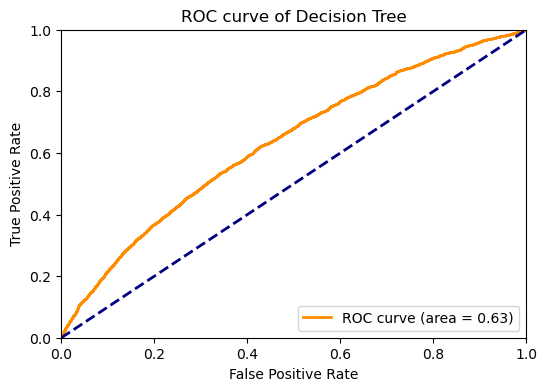

In [103]:
lw=2
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr, color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' %rf_roc_auc_value)
plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision Tree')
plt.legend(loc='lower right')
plt.show()

An AUC of 0.63 indicates that the model has some discriminatory power, as it's performing better than random level which is 0.5.

#### Cumulative Lift

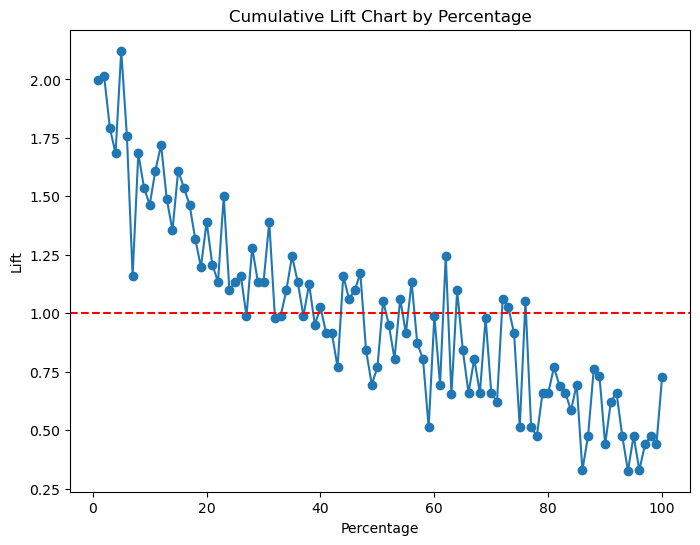

In [104]:
data = pd.DataFrame({'true': RF_actual_predict['actual'], 'pred': RF_actual_predict['pred']})
data = data.sort_values(by='pred', ascending=False)

# Compute overall response rate
overall_rate = data['true'].mean()

# Create deciles
bins = pd.qcut(data['pred'], 100, duplicates='drop')
num_bins = len(bins.cat.categories)
data['percentage'] = pd.qcut(data['pred'], 100, labels=np.arange(100, 100-num_bins, -1), duplicates='drop')

# Compute response rate by percentage
lift_data = data.groupby('percentage')['true'].mean().reset_index()

# Calculate lift
lift_data['lift'] = lift_data['true'] / overall_rate

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lift_data['percentage'], lift_data['lift'], marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Percentage')
plt.ylabel('Lift')
plt.title('Cumulative Lift Chart by Percentage')
plt.show()


The coefficient of improvement over a random model is displayed on the Y-axis. For instance, when I anticipate to catch 10% of the class I am interested in and randomly select 10% of the rows. The lift graph represents if the top 20% of the model's predictions are correctly predicted, I will achieve 1.2 times (or 120%) the positive outcomes I would expect if I targeted without the model.

## 2.2 Over-Sampling - SMOTE

**SMOTE (Synthetic Minority Over-sampling Technique):**
1. An oversampling method to combat imbalanced dataset
2. Generates synthetic samples in the feature space
3. It selects k nearest neighbors, which the number is user-defined 
4. Mitigates the overfitting problems by increasing the size of training data and improving the model performance

### SMOTE

In [107]:
# SMOTE
from imblearn.over_sampling import SMOTE

sampler = SMOTE(sampling_strategy={1: 9013, 0: 34569})
X_rs, y_rs = sampler.fit_resample(X_train, Y_train)
print('SMOTE {}'.format(Counter(y_rs)))
#plot_this(X_rs,y_rs,'SMOTE')

SMOTE Counter({0: 34569, 1: 9013})


In [108]:
df = pd.concat([X_rs, y_rs], axis=1)
df

,AMT_LOAN_TOTAL,LEN_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_3MON,LEN_TOTAL_INBOUND_CALLS_LAST_1MON,LEN_TOP3_FREQUENT_OUTBOUND_PHONE_NUMBERS_OUTBOUND_CALLS_LAST_3MON,CNT_DISTINCT_OUTBOUND_CALLS_LAST_3MON,CNT_TOTAL_OUTBOUND_CALLS_LAST_3MON,CNT_DISTINCT_CALLS_LAST_3MON,CNT_DISTINCT_OUTBOUND_CALLS_LAST_2MON,CNT_DISTINCT_CALLS_LAST_2MON,CNT_TOP3_FREQUENT_INBOUND_PHONE_NUMBERS_INBOUND_CALLS_LAST_2MON,...,TD023,CNT_ABNORMAL_HOURS_CALL_DAYS_LAST_3MON,SCORE_DEBIT_CARD_UTILITY_AMT,CNT_ABNORMAL_HOURS_CALLS_LAST_2MON,AVG_LEN_COLLECTION_OR_HIGH_RISK_INBOUND_CALLS,CNT_ABNORMAL_HOURS_INBOUND_CALLS_LAST_3MON,TD_CNT_QUERY_LAST_3MON_SMALL_LOAN,DAYS_BTW_APPLICATION_AND_FIRST_COLLECTION_OR_HIGH_RISK_CALL,CNT_ABNORMAL_HOURS_OUTBOUND_CALLS_LAST_3MON,Loan_Default
0,52000,21593.0,4268.0,37922.0,107.0,323.0,153.0,56.0,77.0,82.0,...,6.0,7.0,8,6.0,24.0,7.0,1,72.0,5.0,0
1,40250,5352.0,5680.0,5871.0,77.0,169.0,86.0,65.0,74.0,74.0,...,9.0,2.0,5,3.0,19.0,2.0,2,9.0,1.0,0
2,2499,5674.0,6353.0,3456.0,158.0,439.0,192.0,138.0,166.0,179.0,...,3.0,3.0,2,4.0,-98.0,2.0,2,-1.0,2.0,0
3,2000,43833.0,32107.0,81342.0,138.0,1194.0,238.0,105.0,193.0,301.0,...,12.0,2.0,3,4.0,-98.0,4.0,4,-1.0,1.0,0
4,2700,7913.0,11701.0,3265.0,27.0,129.0,44.0,27.0,44.0,42.0,...,6.0,0.0,4,0.0,27.0,0.0,0,14.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43577,0,12481.0,11778.0,26754.0,58.0,268.0,101.0,51.0,75.0,66.0,...,0.0,0.0,6,0.0,-98.0,0.0,2,-1.0,0.0,0
43578,8500,982.0,3452.0,1132.0,22.0,48.0,32.0,22.0,32.0,18.0,...,12.0,0.0,8,0.0,-98.0,0.0,2,-1.0,0.0,0
43579,61800,12551.0,7594.0,20224.0,154.0,217.0,194.0,104.0,134.0,38.0,...,15.0,3.0,8,1.0,24.0,2.0,1,117.0,2.0,0
43580,16298,5537.0,1400.0,5650.0,27.0,50.0,42.0,15.0,21.0,8.0,...,0.0,0.0,7,0.0,-98.0,0.0,2,-1.0,0.0,0


In [109]:
df = pd.concat([X_rs, y_rs], axis=1)
df_hex = h2o.H2OFrame(df)
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


## Random Forest with SMOTE method

In [114]:
def train_model(max_depth, 
                ntrees,
                min_rows, 
                sample_rate, 
                col_sample_rate_per_tree,
                mtries,                  
                build_tree_one_node,      
                min_split_improvement,
                **kwargs):  
    
    params = {
        'max_depth': int(max_depth),
        'ntrees': int(ntrees),
        'min_rows': int(min_rows),
        'sample_rate': sample_rate,
        'col_sample_rate_per_tree': col_sample_rate_per_tree,
        'mtries': int(mtries),  
        'build_tree_one_node': bool(build_tree_one_node),
        'min_split_improvement': min_split_improvement
    }
    
    model = H2ORandomForestEstimator(nfolds=10, **params)
    model.train(x=top_features, y=target, training_frame=train_hex)
    
    return -model.rmse()

#set up params bounds
bounds = {
    'max_depth': (5, 20),                    
    'ntrees': (200, 400),                    
    'min_rows': (20, 80),                    
    'sample_rate': (0.7, 1),                 
    'col_sample_rate_per_tree': (0.6, 1),    
    'mtries': (5, 20),                      
    'build_tree_one_node': (0, 1),        
    'min_split_improvement': (0.001, 0.02)  
}


In [115]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points=15, n_iter=30)

|   iter    |  target   | build_... | col_sa... | max_depth | min_rows  | min_sp... |  mtries   |  ntrees   | sample... |
-------------------------------------------------------------------------------------------------------------------------
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 1         | -0.412    | 0.417     | 0.8881    | 5.002     | 38.14     | 0.003788  | 6.385     | 237.3     | 0.8037    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 2         | -0.4112   | 0.3968    | 0.8155    | 11.29     | 61.11     | 0.004885  | 18.17     | 205.5     | 0.9011    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 3         | -0.4168   | 0.4173    | 0.8235    | 7.106     | 31.89     | 0.01621   | 19.52     | 262.7     | 0.9077    |
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 4       

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 16        | -0.4092   | 0.5591    | 0.8307    | 12.29     | 62.5      | 0.002611  | 11.3      | 338.2     | 0.9553    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 17        | -0.4154   | 0.7714    | 0.6959    | 15.75     | 62.0      | 0.01099   | 9.121     | 334.3     | 0.9751    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 18        | -0.4165   | 0.7119    | 0.8814    | 10.6      | 65.0      | 0.01585   | 10.85     | 381.8     | 0.9953    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 19        | -0.4155   | 0.355     | 0.7723    | 12.49     | 60.88     | 0.01247   | 12.52     | 340.6     | 0.8142    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 20        | -0.4131   | 0.698     | 0.8875    | 14.09     | 63.87     | 0.00623   | 11.37     | 339.7     | 0.8549    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 21        | -0.4168   | 0.462     | 0.6309    | 13.6      | 62.35     | 0.0148    | 9.87      | 337.6     | 0.9037    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 22        | -0.4128   | 0.1284    | 0.9126    | 13.98     | 61.32     | 0.005893  | 11.74     | 337.5     | 0.7465    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 23        | -0.4135   | 0.2469    | 0.6418    | 5.913     | 22.86     | 0.007071  | 18.07     | 218.3     | 0.867     |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 24        | -0.4168   | 0.9682    | 0.8915    | 14.32     | 62.74     | 0.01497   | 12.01     | 338.6     | 0.8979    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 25        | -0.4168   | 0.3043    | 0.8017    | 5.037     | 70.54     | 0.01473   | 8.473     | 208.2     | 0.9291    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 26        | -0.4168   | 0.1512    | 0.7559    | 15.93     | 56.72     | 0.01964   | 8.012     | 308.9     | 0.7347    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 27        | -0.4146   | 0.6462    | 0.9425    | 10.31     | 33.51     | 0.01014   | 11.86     | 382.8     | 0.8236    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 28        | -0.4086   | 0.3222    | 0.6608    | 11.1      | 63.34     | 0.001837  | 9.672     | 229.5     | 0.7083    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 29        | -0.4168   | 0.1593    | 0.8411    | 7.221     | 50.09     | 0.01615   | 16.33     | 310.1     | 0.7765    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 30        | -0.4133   | 0.4164    | 0.6388    | 6.307     | 45.08     | 0.00679   | 15.64     | 211.9     | 0.7443    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
| 31        | -0.4168   | 0.3053    | 0.7788    | 6.883     | 35.0      | 0.01805   | 6.364     | 346.6     | 0.9011    |


C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |█████████████████████████ (failed)


OSError: Job with key $03017f00000132d4ffffffff$_9c5493ccb5931a2b84abdb7512174a6a failed with an exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_model_python_1689949259245_315_cv_5.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (2.1 KB per tree x 327 > 603.4 KB) - try decreasing ntrees and/or max_depth or increasing min_rows!

stacktrace: 
water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for DRF model: DRF_model_python_1689949259245_315_cv_5.  Details: ERRR on field: _ntrees: The tree model will not fit in the driver node's memory (2.1 KB per tree x 327 > 603.4 KB) - try decreasing ntrees and/or max_depth or increasing min_rows!

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:19)
	at hex.tree.SharedTree.doScoringAndSaveModel(SharedTree.java:819)
	at hex.tree.SharedTree$Driver.scoreAndBuildTrees(SharedTree.java:488)
	at hex.tree.SharedTree$Driver.computeImpl(SharedTree.java:405)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:253)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1689)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [ ]:
#get the optimal parameters
optimizer.max

In [112]:
# Optimal parameters from Bayesian Optimization
optimal_params = {
    'build_tree_one_node': 0.5370095085039513,
    'col_sample_rate_per_tree': 0.7907266617893985,
    'max_depth': 20.088748817778363,
    'min_rows': 64.8928688830029,
    'min_split_improvement': 0.013402208746917004,
    'mtries': 59.164656541452835,
    'ntrees': 119.7166505898006,
    'sample_rate': 0.5867588184514467
}

# Convert and round parameters to appropriate datatypes
optimal_params['build_tree_one_node'] = True if optimal_params['build_tree_one_node'] > 0.5 else False
optimal_params['max_depth'] = int(round(optimal_params['max_depth']))
optimal_params['min_rows'] = int(round(optimal_params['min_rows']))
optimal_params['mtries'] = int(round(optimal_params['mtries']))
optimal_params['ntrees'] = int(round(optimal_params['ntrees']))

# Initialize and train the H2O RandomForest model with optimal parameters
RF_modl = H2ORandomForestEstimator(
    model_id = 'RF',
    seed = 1234,
    **optimal_params
)

RF_modl.train(top_features, target, training_frame=train_hex)

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Dropping bad and constant columns: [DATE_APPLIED, FLAG_CREDIT_CARD_ACCT_OVER_8, TD029, TD028, TD027, TD026, TD025]

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

C:\Users\Jessica\AppData\Roaming\Python\Python311\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning:

Single-node tree building is not supported in this version of H2O.



drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: RF


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    120                120                         20753                  1            9            4.95833       1             17            9.1

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.16895086845807428
RMSE: 0.4110363347175944
MAE: 0.3400247235678976
RMSLE: 0.28835389990434707
Mean Residual Deviance: 0.16895086845807428

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-07-21 00:53:58  0.029 sec   0.0                nan                  nan                  nan
     2023-07-21 00:53:58  0.040 sec   1.0                0.4141060859690211   0.3390522091466781   0.1714838504365823
     2023-07-21 00:53:58  0.051 sec   2.0                0.41401700879624487  0.33985279542170205  0.17141008357258988
     2023-07-21 00:53:58  0.059 sec   3.0                0.4124883243681197   0.339476936148151    0.17014661774001913
     2023-07-21 00:53:58  0.065 sec   4.0                0.41324003191344666  0.3411918121396786   0.1707673239758264
     2023-07-21 00:53:58  0.071 sec   5.0                0.41311999308491676  0.3415849126837663   0.17066812868648168
     2023-07-21 00:53:58  0.076 sec   6.0                0.41295981151514266  0.3418889647586413   0.17053580592662215
     2023-07-21 00:53:58  0.118 sec   7.0                0.41259374713525154  0.3417142670393035   0.17023360017510789
     2023-07-21 00:53:58  0.128 sec   8.0                0.41248459108507435  0.3417641956184528   0.170143537882621
     2023-07-21 00:53:58  0.174 sec   9.0                0.4123910391595518   0.34162325814189354  0.17006636917909496
---  ---                  ---         ---                ---                  ---                  ---
     2023-07-21 00:53:59  1.293 sec   111.0              0.41101810061210164  0.3399845364967615   0.16893587903077972
     2023-07-21 00:53:59  1.301 sec   112.0              0.4110127636463298   0.33998439892112636  0.16893149188019377
     2023-07-21 00:53:59  1.309 sec   113.0              0.41100617697164193  0.33996880644155425  0.16892607750884464
     2023-07-21 00:53:59  1.319 sec   114.0              0.4110137513631585   0.33999273588999795  0.16893230380961627
     2023-07-21 00:53:59  1.324 sec   115.0              0.4110200568471612   0.340009879654981    0.1689374871306436
     2023-07-21 00:53:59  1.333 sec   116.0              0.4110131055596305   0.3399923513619601   0.16893177294177197
     2023-07-21 00:53:59  1.338 sec   117.0              0.41101986161726584  0.34000677702755505  0.16893732664387637
     2023-07-21 00:53:59  1.342 sec   118.0              0.4110345008006848   0.3400383333959239   0.16894936084846815
     2023-07-21 00:53:59  1.349 sec   119.0              0.41102949958938934  0.34002192747425297  0.16894524953270382
     2023-07-21 00:53:59  1.357 sec   120.0              0.4110363347175944   0.3400247235678976   0.16895086845807428
[121 rows x 7 columns]


Variable Importances: 
variable                                       relative_importance    scaled_importance       percentage
---------------------------------------------  ---------------------  ----------------------  ---------------------
TD_CNT_QUERY_LAST_6MON_P2P                     6833.35205078125       1.0                     0.5110703291118414
LOAN_TERM                                      2454.62548828125       0.35921250215706585     0.18358285169849967
CODE_EDUCATIO

In [113]:
def actual_predict(model,test_hex,target):
    y_pred = model.predict(test_hex).as_data_frame()
    y_actual = test_hex[target].as_data_frame()
    df_actual_predict = pd.concat([y_actual,y_pred],axis=1)
    df_actual_predict.columns = ['actual','pred']
    return(df_actual_predict)

RF_actual_predict = actual_predict(RF_modl,test_hex,target)
RF_actual_predict.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,actual,pred
0,0,0.331764
1,0,0.296735
2,0,0.239979
3,0,0.179492
4,0,0.341607


### Performance

#### ROC

In [114]:
rf_roc_auc_value = roc_auc_score(RF_actual_predict['actual'],RF_actual_predict['pred'])
rf_roc_auc_value

0.6121787501330778

In [115]:
fpr, tpr, _ = roc_curve(RF_actual_predict['actual'], RF_actual_predict['pred'])
[fpr,tpr]

[array([0.00000000e+00, 0.00000000e+00, 8.51698073e-04, 1.17108485e-03,
        1.27754711e-03, 2.34216970e-03, 2.44863196e-03, 2.55509422e-03,
        2.66155648e-03, 2.76801874e-03, 2.87448100e-03, 3.08740551e-03,
        3.40679229e-03, 3.61971681e-03, 4.36495262e-03, 4.47141488e-03,
        4.47141488e-03, 4.68433940e-03, 5.00372618e-03, 5.42957522e-03,
        5.53603747e-03, 5.53603747e-03, 5.96188651e-03, 5.96188651e-03,
        6.06834877e-03, 6.06834877e-03, 6.28127329e-03, 6.60066007e-03,
        6.70712233e-03, 6.92004684e-03, 7.34589588e-03, 7.45235814e-03,
        7.77174492e-03, 7.77174492e-03, 7.87820718e-03, 8.19759395e-03,
        9.04929203e-03, 1.06462259e-02, 1.07526882e-02, 1.11785372e-02,
        1.13914617e-02, 1.19237730e-02, 1.21366975e-02, 1.22431598e-02,
        1.22431598e-02, 1.39465559e-02, 1.63951879e-02, 1.66081124e-02,
        1.72468860e-02, 1.73533482e-02, 1.78856595e-02, 1.80985841e-02,
        1.92696689e-02, 1.92696689e-02, 1.93761312e-02, 1.958905

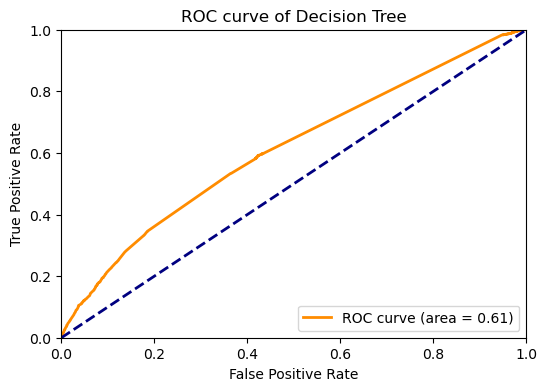

In [116]:
lw=2
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr, color='darkorange',lw=lw,label='ROC curve (area = %0.2f)' %rf_roc_auc_value)
plt.plot([0,1],[0,1], color='navy',lw=lw,linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Decision Tree')
plt.legend(loc='lower right')
plt.show()

The performance of ROC curve here is actually the same as the curve under the under sampling model. This could due to the Random Forest algorithm, by its ensemble nature, tends to be more robust against imbalances in the training data than simpler algorithms, which means that it might produce fairly consistent predictions, irrespective of whether I've balanced the dataset or not.

#### Cumulative Lift

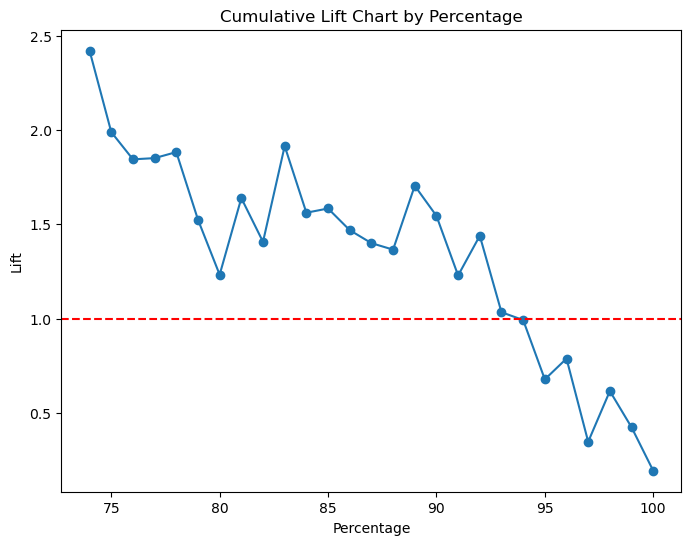

In [117]:
data = pd.DataFrame({'true': RF_actual_predict['actual'], 'pred': RF_actual_predict['pred']})
data = data.sort_values(by='pred', ascending=False)

# Compute overall response rate
overall_rate = data['true'].mean()

# Create deciles
bins = pd.qcut(data['pred'], 100, duplicates='drop')
num_bins = len(bins.cat.categories)
data['percentage'] = pd.qcut(data['pred'], 100, labels=np.arange(100, 100-num_bins, -1), duplicates='drop')

# Compute response rate by percentage
lift_data = data.groupby('percentage')['true'].mean().reset_index()

# Calculate lift
lift_data['lift'] = lift_data['true'] / overall_rate

# Plot
plt.figure(figsize=(8, 6))
plt.plot(lift_data['percentage'], lift_data['lift'], marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Percentage')
plt.ylabel('Lift')
plt.title('Cumulative Lift Chart by Percentage')
plt.show()

The performance of cumulative lift curve here is actually the same as the curve under the under sampling model. This could due to the Random Forest algorithm, by its ensemble nature, tends to be more robust against imbalances in the training data than simpler algorithms, which means that it might produce fairly consistent predictions. If the initial class imbalance isn't too severe, the performance difference before and after re-sampling might be minimal. Random Forest can sometimes handle mildly imbalanced datasets without a significant drop in performance.